# Data

## Downloading the data

In [1]:
! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy

## Import dependencies

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/ConvLSTM2') # path where the checkpoints folder is

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as T


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Import data and dataloader

In [5]:
def invert_image(video):
    """ 
    This function is for inverting the color of 
    the original frames to create the augmented dataset. 
    """
    torch.manual_seed(0)
    final_gif = []
    for frame in video:
        new_image = Image.fromarray(frame).convert('L')
        new_image = T.functional.invert(new_image)
        new_image = np.asarray(new_image) 
        final_gif.append(new_image)

    final_gif = np.array(final_gif)

    return final_gif

In [6]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)


# Shuffle Data
np.random.shuffle(MovingMNIST)


# Augmented dataset
augmented_dataset = []
for index, video in enumerate(MovingMNIST):
    augmented_dataset.append(video)
    augmented_dataset.append(invert_image(video))
augmented_dataset = np.array(augmented_dataset)


# Train, Test, Validation splits  
train_data = MovingMNIST[:2000]         
val_data = MovingMNIST[2000:2256]       
test_data = MovingMNIST[2256:2512]  


# Augmented Train, Test, Validation splits
augtrain_data = augmented_dataset[:5000]
augval_data = augmented_dataset[5000:5500]
augtest_data = augmented_dataset[5500:6000]


def collate(batch):
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(8,20)                     
    return batch[:,:,rand-8:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Augmented training data loader
augtrain_loader = DataLoader(augtrain_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
augval_loader = DataLoader(augval_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

## Visualize the data 

### Regular data

In [7]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

<ipython-input-6-e4ee6df9da8f>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch = torch.tensor(batch).unsqueeze(1)


### Augmented data

In [8]:
# Get a batch
auginput, _ = next(iter(augval_loader))

# Reverse process before displaying
auginput = auginput.cpu().numpy() * 255.0     

for video in auginput.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

# Model


In [9]:
def double_conv(in_channels, out_channels):
      conv = nn.Sequential(
          nn.Conv3d(in_channels,out_channels, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
          nn.ReLU(inplace=True)
      )
      return conv
  
class Seq2Seq(nn.Module):
      def __init__(self, in_channels, out_channels):
          super(Seq2Seq, self).__init__()
  
          self.max_pool_2x2_1 = nn.MaxPool3d(kernel_size=2, stride=2)
          self.max_pool_2x2_2 = nn.MaxPool3d(kernel_size=2, stride=2)
          self.max_pool_2x2_3 = nn.MaxPool3d(kernel_size=2, stride=2)
          self.max_pool_2x2_4 = nn.MaxPool3d(kernel_size=2, stride=2)
          self.max_pool_2x2_5 = nn.MaxPool3d(kernel_size=2, stride=2)
          self.down_conv_1 = double_conv(in_channels, 16)
          self.down_conv_2 = double_conv(16, 32)
          self.down_conv_3 = double_conv(32, 64)
          self.down_conv_4 = double_conv(64, 128)
  
          self.up_conv_trans3 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
          self.up_conv_3 = double_conv(128, 64)
  
          self.up_conv_trans4 = nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
          self.up_conv_4 = double_conv(64, 32)
  
          self.up_conv_trans5 = nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
          self.up_conv_5 = double_conv(32, 16)
  
          self.out = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1)
  
  
      def forward(self, image):
          out_conv1 = self.down_conv_1(image)
          out_pool1 = self.max_pool_2x2_1(out_conv1)
          out_conv2 = self.down_conv_2(out_pool1)
          out_pool2 = self.max_pool_2x2_2(out_conv2)
          out_conv3 = self.down_conv_3(out_pool2)
          out_pool3 = self.max_pool_2x2_3(out_conv3)
          out_conv4 = self.down_conv_4(out_pool3)

          #decoder part
          out_up_conv = self.up_conv_trans3(out_conv4)

          out_up_conv = self.up_conv_3(torch.cat([out_up_conv, out_conv3], 1))
          out_up_conv = self.up_conv_trans4(out_up_conv)

          out_up_conv = self.up_conv_4(torch.cat([out_up_conv, out_conv2], 1))
          out_up_conv = self.up_conv_trans5(out_up_conv)

          out_up_conv = self.up_conv_5(torch.cat([out_up_conv, out_conv1], 1))

          out_up_conv = self.out(out_up_conv[:,:,-1])
          out_up_conv = torch.sigmoid(out_up_conv)
          
          return out_up_conv

## Instantiate the model

In [10]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(1,1).to(device)

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

## Training

In [11]:
def plot_loss(iters_sub, train_loss, val_loss):
    """
    Plot the loss curve.
    """
    plt.title("Loss Curve: Loss per Iteration")
    plt.plot(iters_sub, train_loss, label="Train")
    plt.plot(iters_sub, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.show()

Epoch:1 Training Loss:1484.07 Validation Loss:734.74

Epoch:2 Training Loss:581.83 Validation Loss:448.98

Epoch:3 Training Loss:395.20 Validation Loss:365.30

Epoch:4 Training Loss:361.49 Validation Loss:351.68

Epoch:5 Training Loss:348.23 Validation Loss:346.08

Epoch:6 Training Loss:339.49 Validation Loss:337.66

Epoch:7 Training Loss:334.00 Validation Loss:325.34

Epoch:8 Training Loss:330.98 Validation Loss:329.59

Epoch:9 Training Loss:327.75 Validation Loss:325.39

Epoch:10 Training Loss:325.47 Validation Loss:323.01



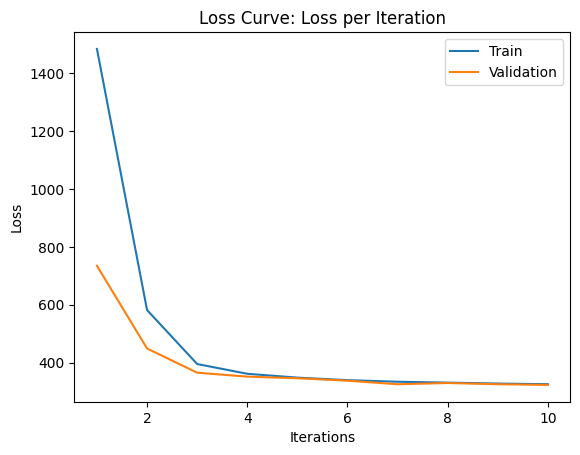

In [12]:
num_epochs = 10
checkpoint_path = '/content/gdrive/MyDrive/ConvLSTM2/checkpoints/ckpt-{}.pk' # the path where the checkpoints will be saved
n = 0

train_loss_list = []
val_loss_list = []
epoch_list = []

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):
        output = model(input)   
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward() 
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        n+=1
        if n%10 ==0:
            torch.save(model.state_dict(), checkpoint_path.format(n)) 
                                      
    train_loss /= len(train_loader.dataset)                       
     
    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)      

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    epoch_list.append(epoch)                        

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))
    
plot_loss(epoch_list, train_loss_list, val_loss_list)

## Visualize what the model learned

In [13]:
def collate_test(batch):
    # Last 10 frames are target
    target = np.array(batch)[:,8:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=16, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+8] 
  output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [14]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))